In [16]:
from sm_data import generate_prediction_data, generate_NPI_prediction_data, generate_ground_truth_forecast, get_isolation_data_model, get_test_positivity_data_model
from covid.patients import get_delay_distribution, get_delays_from_patient_data, download_patient_data
from sm_utils import *
from sm_utils import _get_convolution_ready_gt
from sm_model import SemiMechanisticModels

In [17]:
import pandas as pd 
import numpy as np 
import pymc3 as pm 
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import os 
import argparse

In [31]:
end_date = 136
prediction_t = 14

separate_dorms = True
separate_quarantine = True
val_run = False
start_id = 50

In [32]:
DATA_PATH = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_curve.csv')
NPI_PATH = 'data/NPIS_LC_processed_V4.csv'

QUARANTINE_DATA_PATH =  '../covid19-modelling-sg/data/statistics/active_number_under_quarantine.csv'
SHN_DATA_PATH = '../covid19-modelling-sg/data/statistics/individuals_under_shn.csv'
TESTS_COUNTS_OWID_PATH = '../Data/owid-covid-data.csv'
TEST_COUNTS_REPO_PATH = '../covid19-modelling-sg/data/statistics/swab_figures.csv'
CASE_BREAKDOWN_PATH = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_split_curve.csv')

In [33]:
community_input, dorm_input, imported_input, total_input, len_observed = generate_prediction_data(DATA_PATH, start_id=start_id,
                            end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma',
                            separate_dorms=separate_dorms, separate_quarantine=separate_quarantine,
                            local_cases_breakdown_data_path=CASE_BREAKDOWN_PATH)

if val_run:
    com_gt, dorm_gt, import_gt, total_gt = generate_ground_truth_forecast(DATA_PATH, start_id=start_id,
                        end_date=end_date, prediction_t=prediction_t)


NPIS_array, date_ver = generate_NPI_prediction_data(NPI_PATH, start_id=start_id, end_date=end_date, prediction_t=prediction_t)

num_NPIS = NPIS_array.shape[1]
get_isolation_data_model, get_test_positivity_data_model

if separate_quarantine:
    quarantine_stats = get_isolation_data_model(SHN_DATA_PATH, QUARANTINE_DATA_PATH,
                     DATA_PATH, start_id, end_date,
                     shn_start_val=0, prediction_t=prediction_t,
                     quarantine_start_val=0, scale=True,extrapolate_type='ma')

    test_stats = get_test_positivity_data_model(TESTS_COUNTS_OWID_PATH, TEST_COUNTS_REPO_PATH,
                          DATA_PATH, start_id,
                          end_date, prediction_t=prediction_t, start_val=100, scale=True,
                          extrapolate_type='ma')
else:
    quarantine_stats = None
    test_stats = None

imported cases ma
Length Community training cases:  150   150
Length Dorm training cases:  136
Length into model:  150   150   150
imported cases ma
imported cases ma


In [34]:
# TRAIN MODEL
sm_forecast = SemiMechanisticModels()
# Instatiate model based on data
sm_forecast.build_model(local_cases=community_input,
                        dorm_cases=dorm_input,
                        imported_cases=imported_input,
                        NPIS_array=NPIS_array,
                        len_observed=len_observed,
                        total_cases=None,
                        separate_dorms=separate_dorms,
                        separate_quarantine=separate_quarantine,
                        test_counts=test_stats,
                        quarantine_counts=quarantine_stats,
                        prediction_t=prediction_t,
                        likelihood_fun='PO')

hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local_q contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_dorm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [35]:
trace_folder = '../Temp Results'
#trace_name = 'SM_V2_Trace_Start_115_prediction_ahead_2_1500_3500_id_080e024a933743c69ef296a4a12e2c07'
#trace_name = 'SM_V2_Trace_Start_122_prediction_ahead_2_1500_3500_id_eadc2ed9b8e64029ad76ce17cdc64e47'
trace_name = 'SM_V2_Trace_Start_136_prediction_ahead_2_1500_3500_id_a21488ca17324e3f93465f24e8f650b6'
full_trace_name = os.path.join(trace_folder, trace_name)

In [36]:
with sm_forecast.model:
    loaded_trace = pm.load_trace(full_trace_name)

In [37]:
sm_forecast._trace = loaded_trace

## Energy

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


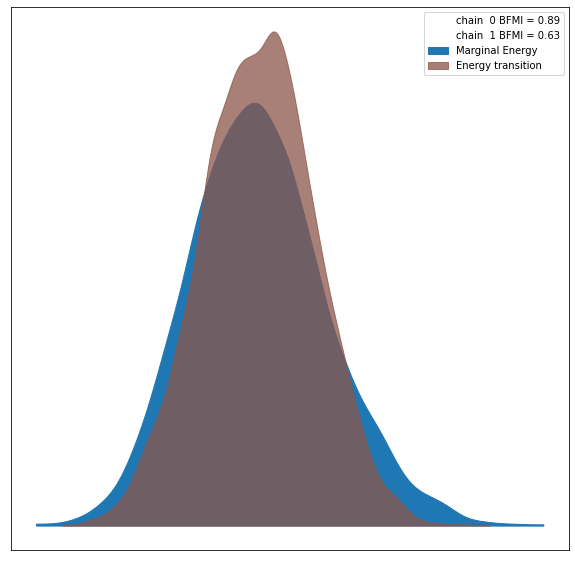

In [38]:
sm_forecast.plot_energy(save=False)

## Latents

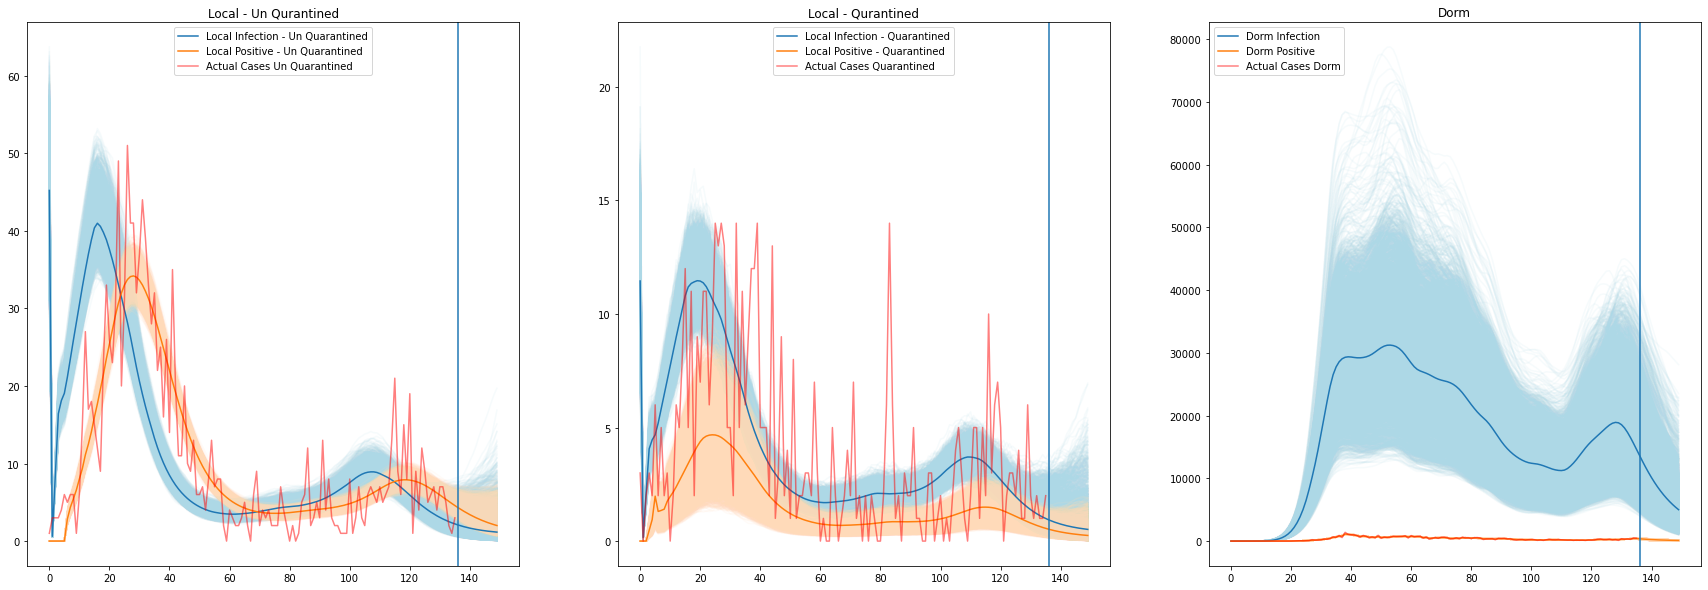

In [39]:
sm_forecast.plot_latents(save=False, show=True)

## R_t

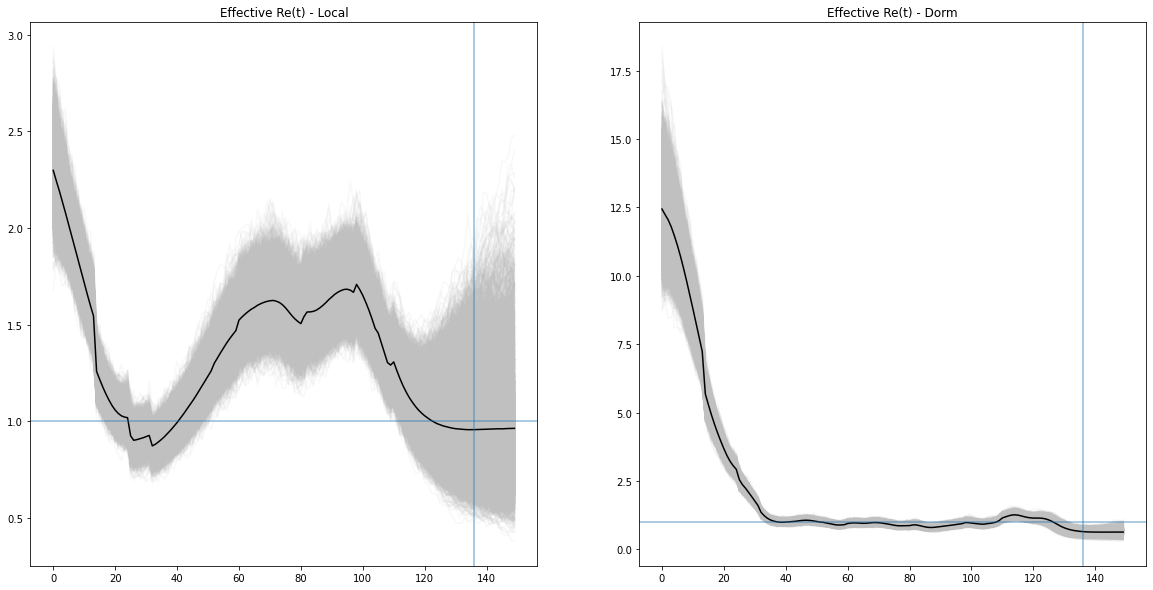

In [40]:
sm_forecast.plot_rt(save=False, show=True)

# Predictions

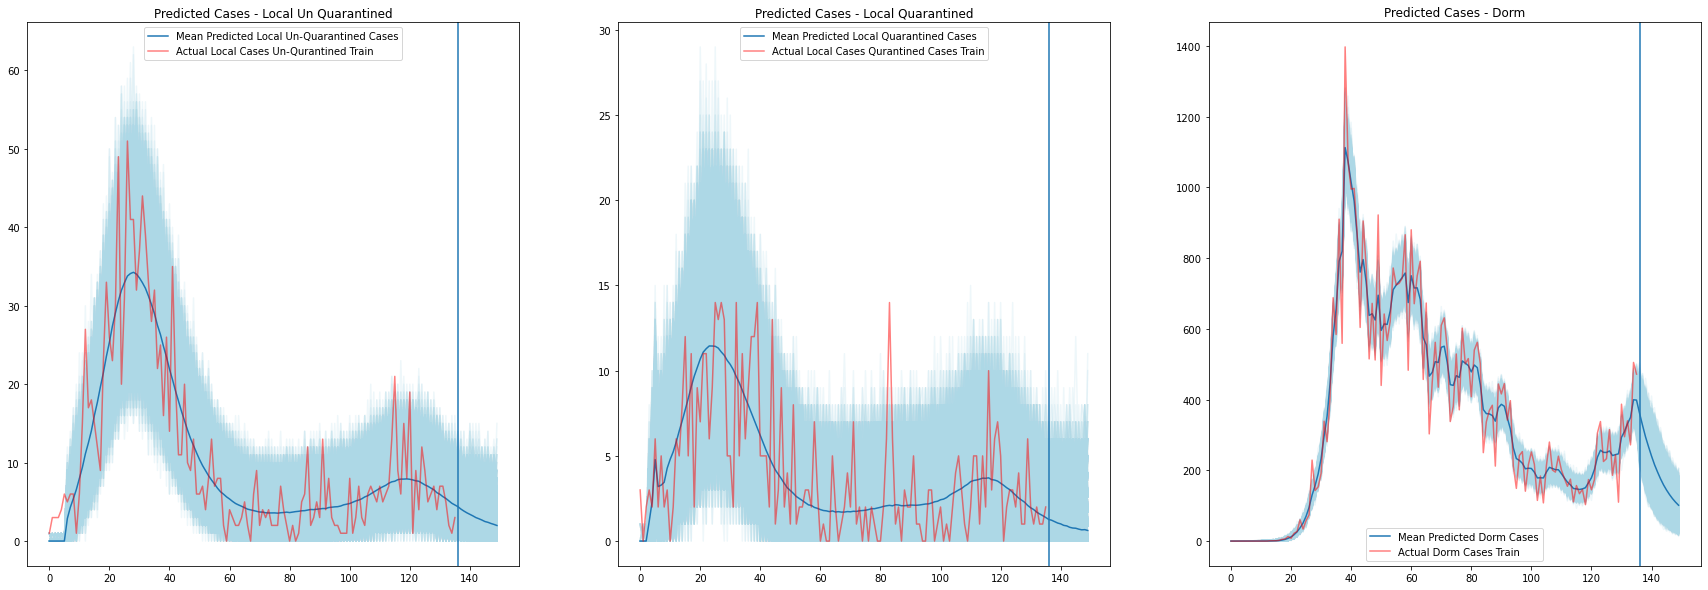

In [41]:
sm_forecast.plot_predictions(save=False, show=True)

# Alpha

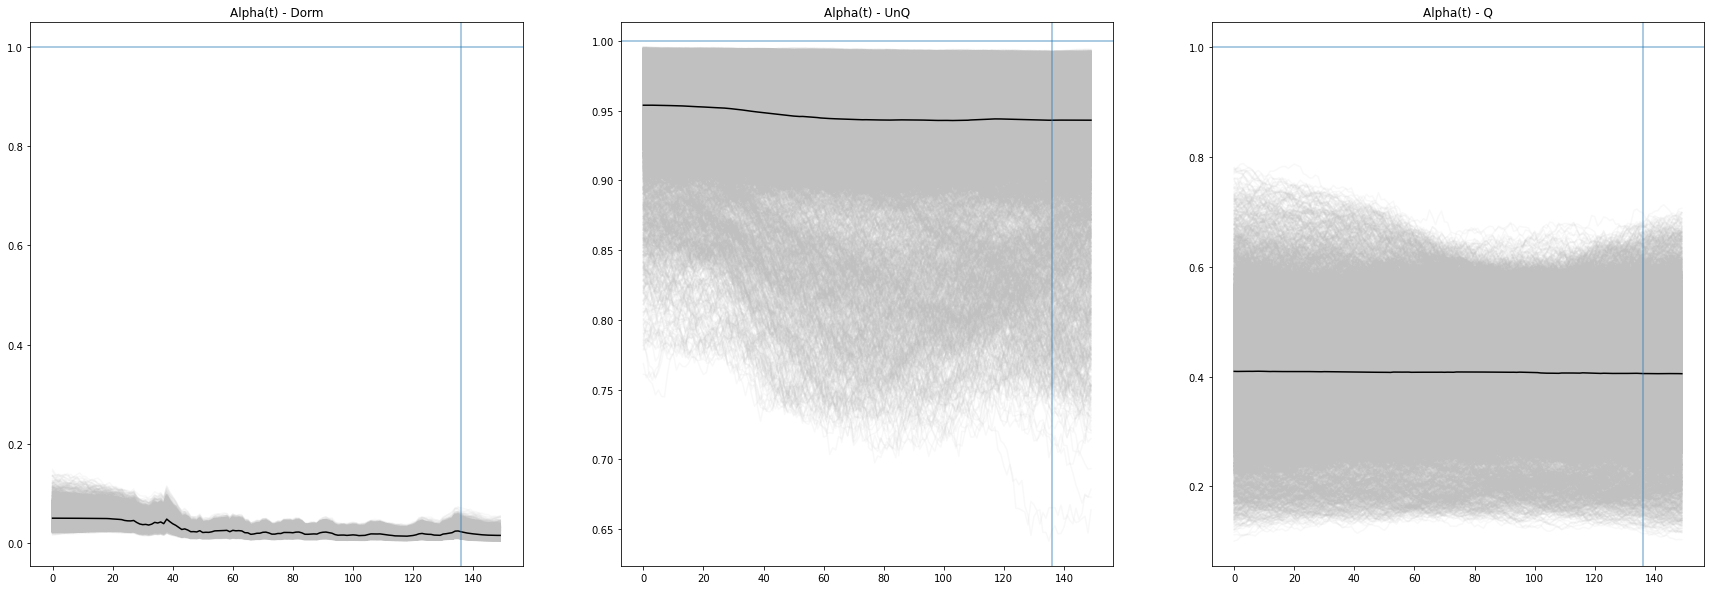

In [42]:
sm_forecast.plot_alpha_t(save=False, show=True)

# Quarantine

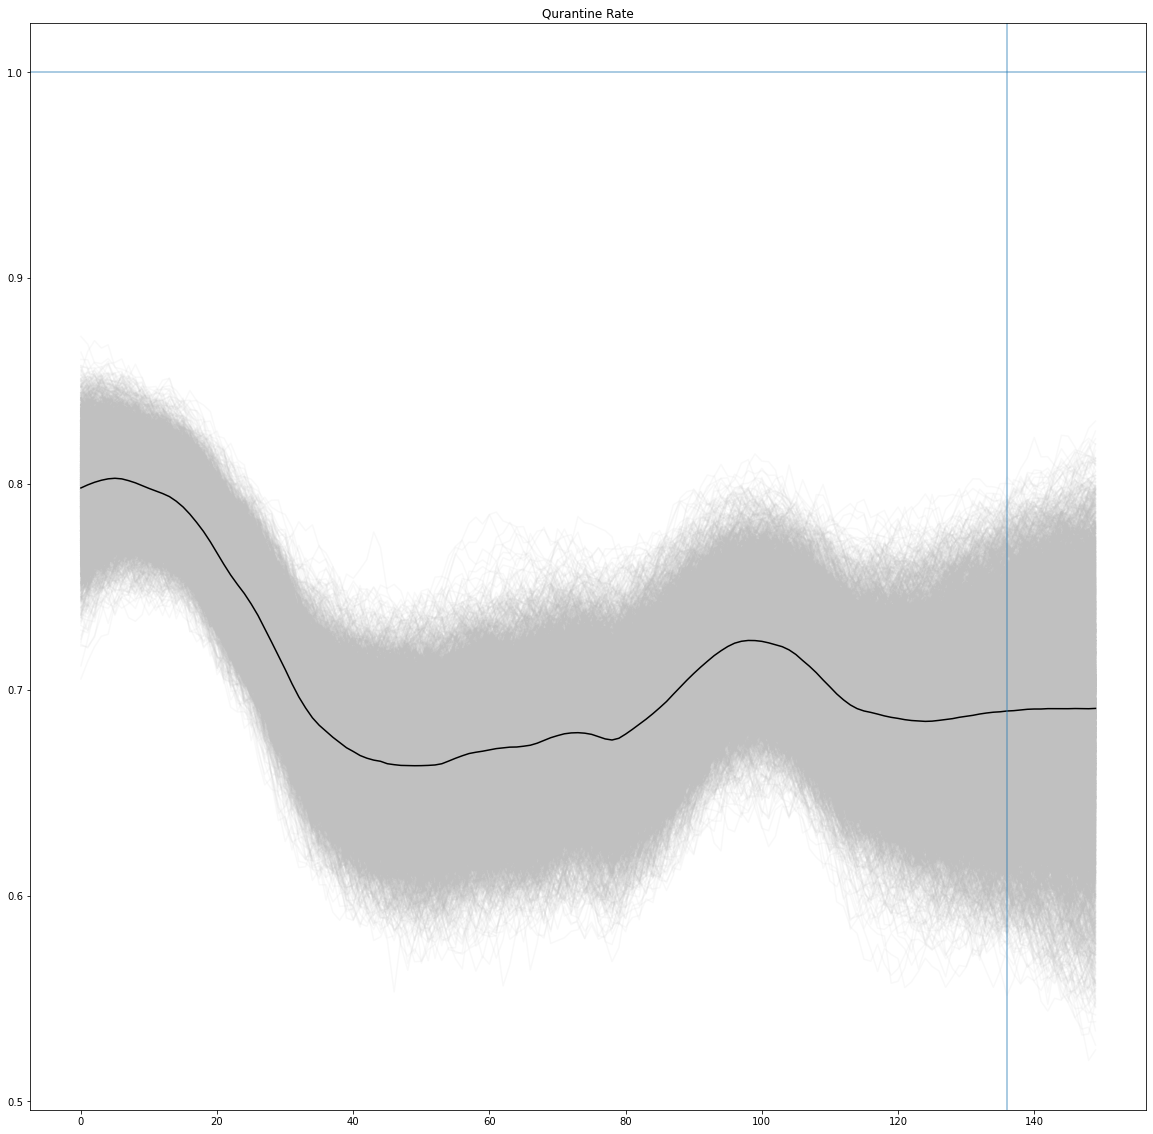

In [43]:
sm_forecast.plot_quarantine_rate(save=False, show=True)

- Mixture model for variants
- Limit on number of dormitory workers
- Exponential thingy 
- Yee Ying Info
- Parallel coding
- Use samples (Multi-Trace object)
- Week by week basis -> Posterior to prior **
- Vaccination with Serene

In [45]:
sm_forecast._trace['beta_test_dorm']

array([-0.10053466, -0.05993271,  0.07617159, ...,  0.02219295,
        0.07966742,  0.02527439])

(array([  14.,   71.,  325., 1040., 1784., 1971., 1209.,  468.,   95.,
          23.]),
 array([-0.12898089, -0.09920933, -0.06943777, -0.03966621, -0.00989464,
         0.01987692,  0.04964848,  0.07942004,  0.1091916 ,  0.13896316,
         0.16873473]),
 <BarContainer object of 10 artists>)

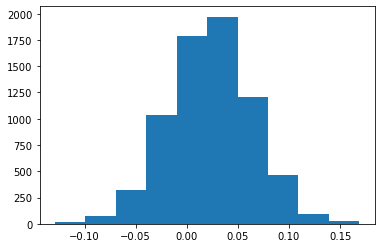

In [47]:
plt.hist(sm_forecast._trace['beta_test_dorm'])

In [46]:
az.summary(sm_forecast._trace, 'beta_test_dorm')

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_test_dorm,0.023,0.041,-0.053,0.101,0.0,0.0,7360.0,4998.0,1.0


In [48]:
sm_forecast._trace.varnames

['log_r_t_foreign',
 'log_r_t_local',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'eps_t_logodds__',
 'Seed_dorm_log__',
 'log_lambda_t',
 'beta_quarantine',
 'Seed_local_log__',
 'log_alpha_dorm_t',
 'log_alpha_unQ_t',
 'log_alpha_Q_t',
 'beta_quarantine_hier_mean',
 'test_dorm_tilde',
 'test_unQ_tilde',
 'test_Q_tilde',
 'Obs_local_missing',
 'Obs_local_q_missing',
 'Obs_dorm_missing',
 'r_t_foreign',
 'r_t_local',
 'eps_t',
 'Seed_dorm',
 'infections_dorm',
 'Q Rate',
 'Seed_local',
 'infections_local_uncontained',
 'infections_rate',
 'infections_local_contained',
 'beta_test_dorm',
 'beta_test_unQ',
 'beta_test_Q',
 'alpha_dorm_t',
 'alpha_local_unQ_t',
 'alpha_local_Q_t',
 'test adjusted positive local',
 'test_adjusted_positive_jit_local',
 'test adjusted positive local Qurantined',
 'test_adjusted_positive_jit_local_qurantined',
 'test adjusted positive dorm',
 'test_adjusted_positive_jit_dorm']

In [49]:
az.summary(sm_forecast._trace, 'beta_test_unQ')

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_test_unQ,0.012,0.042,-0.067,0.09,0.0,0.0,8109.0,5861.0,1.0


In [50]:
az.summary(sm_forecast._trace, 'beta_test_Q')

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_test_Q,0.012,0.042,-0.065,0.096,0.0,0.0,7279.0,5298.0,1.0


In [ ]:
N(0, 0.03)

In [129]:
def calc_time(total, cps):
    seconds_needed = total/cps

    mins_needed = seconds_needed/60

    hours_needed, remainder_mins = divmod(mins_needed, 60)

    print(f"{int(hours_needed)} hr {remainder_mins} mins")

In [193]:
calc_time(700000, 352.5)

0 hr 33.09692671394799 mins


In [144]:
(6000*0.8 + 500) * 12 + (63600 * 0.1 * 0.8)

68688.0